# Annotate enhancers by
- distance to the nearest gene
- GC content

In [1]:
import sys
import importlib
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')
sys.path.insert(0, '/cndd2/fangming/projects/scf_enhancers/scripts/scf_enhancer_paper')
from __init__ import *
import __init__jupyterlab
importlib.reload(__init__jupyterlab)
from __init__jupyterlab import *

import re 
import tqdm
import pickle
import collections
import itertools
import tables

from scipy import sparse
from scipy import stats
from scipy import optimize 
import scipy.cluster.hierarchy as sch
from statsmodels.stats.multitest import multipletests

import snmcseq_utils
importlib.reload(snmcseq_utils)
import CEMBA_clst_utils
importlib.reload(CEMBA_clst_utils)
import enhancer_gene_utils 
importlib.reload(enhancer_gene_utils)

<module 'enhancer_gene_utils' from '/cndd2/fangming/projects/scf_enhancers/scripts/scf_enhancer_paper/enhancer_gene_utils.py'>

In [2]:
# genes
# enhs
# to_evals
f = '/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/organized_for_jupyter/genes_list.tsv'
genes_list = pd.read_csv(f, sep='\t', index_col=False)
print(genes_list.shape)

# enh list
f = '/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/organized_for_jupyter/enhs_list.tsv'
enh_list = pd.read_csv(f, sep='\t', index_col=False)
print(enh_list.shape)

# pair list
f = '/cndd2/fangming/projects/scf_enhancers/results/200521_to_evals_appended_201212.tsv' 
to_evals = pd.read_csv(f, sep='\t', index_col=False)
to_evals = to_evals.astype({'dist': np.int, 'enh': np.int, 'is_in_genebody': np.bool_})

print(to_evals.shape)

(31053, 11)


/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(233514, 7)
(2589994, 4)


In [3]:
gid_to_gname = genes_list.groupby('gid').first()['gene_name'] 
gname_to_gid = genes_list.groupby('gene_name').first()['gid']

def gname_to_gid_nan(name):
    try:
        return gname_to_gid[name]
    except:
        return np.nan

### nearest gene

In [4]:
f = '/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/organized_for_jupyter/enhancer_nearest_genes.bed'
regions_info = pd.read_csv(f, sep='\t', header=None, dtype={0: str, 4: str}, 
                           names=['chr', 'start', 'end', 
                                  'trpt_chr', 'trpt_start', 'trpt_end', 
                                  'strand', 
                                  'trpt_id', 'trpt_name',
                                  'gene_id', 'gene_name',
                                  'dist',
                                 ]
                          )

print(regions_info.shape)
print(enh_list.shape)
# expand enh_list
enh_list_expand = pd.merge(enh_list, regions_info, on=['chr', 'start', 'end'], how='left')
print(enh_list_expand.shape)
enh_list_expand.head()

(233514, 12)
(233514, 7)
(233514, 16)


,index,chr,start,end,length,chrom,center,trpt_chr,trpt_start,trpt_end,strand,trpt_id,trpt_name,gene_id,gene_name,dist
0,0,chr1,3083769,3083816,47,1,3083792,chr1,3073253,3073254,+,ENSMUST00000193812.1,4933401J01Rik-201,ENSMUSG00000102693.1,4933401J01Rik,10516
1,1,chr1,3112234,3112467,233,1,3112350,chr1,3102016,3102017,+,ENSMUST00000082908.1,Gm26206-201,ENSMUSG00000064842.1,Gm26206,10218
2,2,chr1,3112770,3112986,216,1,3112878,chr1,3102016,3102017,+,ENSMUST00000082908.1,Gm26206-201,ENSMUSG00000064842.1,Gm26206,10754
3,3,chr1,3113717,3114035,318,1,3113876,chr1,3102016,3102017,+,ENSMUST00000082908.1,Gm26206-201,ENSMUSG00000064842.1,Gm26206,11701
4,4,chr1,3118790,3118935,145,1,3118862,chr1,3102016,3102017,+,ENSMUST00000082908.1,Gm26206-201,ENSMUSG00000064842.1,Gm26206,16774


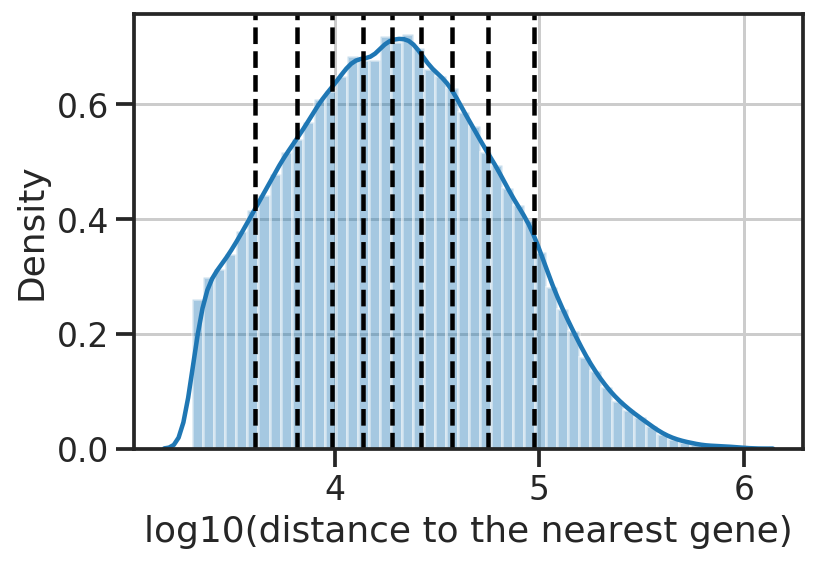

In [5]:
fig, ax = plt.subplots()
_x = np.log10(enh_list_expand['dist'].values)
sns.distplot(_x)
ax.set_xlabel('log10(distance to the nearest gene)')
ax.set_ylabel('Density')

# decile
for i in np.arange(10, 100, 10):
    ax.axvline(np.percentile(_x, i), color='k', linestyle='--')
plt.show()

### GC content 
- get sequences
- compute number of gc's
- normalize by length

In [6]:
# get sequences
!bedtools getfasta \
    -tab \
    -fi "/cndd/fangming/iGenome/mm10/genome.fa" \
    -bed "/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_allresolutions/organized_for_jupyter/enhs_list.bed" \
    -fo "/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_allresolutions/organized_for_jupyter/enhs_sequences.tsv"

In [7]:
# compute the number of sequences
f = '/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_allresolutions/organized_for_jupyter/enhs_sequences.tsv'
enh_seqs = pd.read_csv(f, sep='\t', header=None, names=['enh', 'seq']) 
enh_seqs.head()

,enh,seq
0,chr1:3083769-3083816,ggtggtggtgcatgcctttaattccagcacttgggaggcatagccac
1,chr1:3112234-3112467,ggcttttctgcttccctaattaatgcagtctcgggtcccaagtgat...
2,chr1:3112770-3112986,gcacaatcttgtgaccatagtaCAGATATTCAACAGATAAATTTTG...
3,chr1:3113717-3114035,gaggtggagataaacagcttgcttctgccatgttctgcagaacagc...
4,chr1:3118790-3118935,gagagggccataggacgagcctgagggagagacagctgaaatgtac...


In [8]:
# get GC content; proper normalization
def get_gc_content(seq):
    """
    """
    seq = seq.upper()
    num = seq.count('G') + seq.count('C')
    frac = num/len(seq)
    return num, frac

In [9]:
# 
enh_seqs['GC_num'] = enh_seqs['seq'].apply(lambda x: get_gc_content(x)[0])
enh_seqs['GC_frac'] = enh_seqs['seq'].apply(lambda x: get_gc_content(x)[1])
print(enh_seqs.shape)
enh_seqs.head()

(233514, 4)


,enh,seq,GC_num,GC_frac
0,chr1:3083769-3083816,ggtggtggtgcatgcctttaattccagcacttgggaggcatagccac,26,0.553191
1,chr1:3112234-3112467,ggcttttctgcttccctaattaatgcagtctcgggtcccaagtgat...,117,0.502146
2,chr1:3112770-3112986,gcacaatcttgtgaccatagtaCAGATATTCAACAGATAAATTTTG...,76,0.351852
3,chr1:3113717-3114035,gaggtggagataaacagcttgcttctgccatgttctgcagaacagc...,120,0.377358
4,chr1:3118790-3118935,gagagggccataggacgagcctgagggagagacagctgaaatgtac...,72,0.496552


Text(0, 0.5, 'Density')

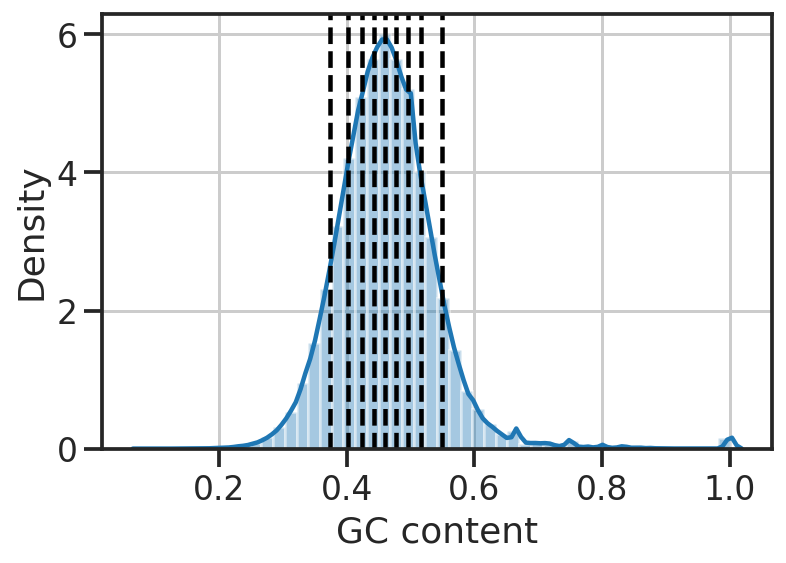

In [10]:
fig, ax = plt.subplots()
_x = enh_seqs['GC_frac'].values
sns.distplot(_x, ax=ax)
# decile
for i in np.arange(10, 100, 10):
    ax.axvline(np.percentile(_x, i), color='k', linestyle='--')
ax.set_xlabel('GC content')
ax.set_ylabel('Density')

# Combine both info

In [27]:
print(enh_seqs.shape, enh_list_expand.shape)

(233514, 4) (233514, 16)


In [28]:
enh_seqs.head()

,enh,seq,GC_num,GC_frac
0,chr1:3083769-3083816,ggtggtggtgcatgcctttaattccagcacttgggaggcatagccac,26,0.553191
1,chr1:3112234-3112467,ggcttttctgcttccctaattaatgcagtctcgggtcccaagtgat...,117,0.502146
2,chr1:3112770-3112986,gcacaatcttgtgaccatagtaCAGATATTCAACAGATAAATTTTG...,76,0.351852
3,chr1:3113717-3114035,gaggtggagataaacagcttgcttctgccatgttctgcagaacagc...,120,0.377358
4,chr1:3118790-3118935,gagagggccataggacgagcctgagggagagacagctgaaatgtac...,72,0.496552


In [29]:
enh_list_expand.head()

,index,chr,start,end,length,chrom,center,trpt_chr,trpt_start,trpt_end,strand,trpt_id,trpt_name,gene_id,gene_name,dist
0,0,chr1,3083769,3083816,47,1,3083792,chr1,3073253,3073254,+,ENSMUST00000193812.1,4933401J01Rik-201,ENSMUSG00000102693.1,4933401J01Rik,10516
1,1,chr1,3112234,3112467,233,1,3112350,chr1,3102016,3102017,+,ENSMUST00000082908.1,Gm26206-201,ENSMUSG00000064842.1,Gm26206,10218
2,2,chr1,3112770,3112986,216,1,3112878,chr1,3102016,3102017,+,ENSMUST00000082908.1,Gm26206-201,ENSMUSG00000064842.1,Gm26206,10754
3,3,chr1,3113717,3114035,318,1,3113876,chr1,3102016,3102017,+,ENSMUST00000082908.1,Gm26206-201,ENSMUSG00000064842.1,Gm26206,11701
4,4,chr1,3118790,3118935,145,1,3118862,chr1,3102016,3102017,+,ENSMUST00000082908.1,Gm26206-201,ENSMUSG00000064842.1,Gm26206,16774


In [34]:
# check the two tables agree
coords = (enh_list_expand['chr']
          + ":" + enh_list_expand['start'].astype(str)
          + "-" + enh_list_expand['end'].astype(str)
         ).values
np.all(enh_seqs['enh'].values == coords)

True

In [35]:
# combined
enh_annot = enh_list_expand.copy()
enh_annot['GC_frac'] = enh_seqs['GC_frac'] 

print(enh_annot.shape)
enh_annot.head()

(233514, 17)


,index,chr,start,end,length,chrom,center,trpt_chr,trpt_start,trpt_end,strand,trpt_id,trpt_name,gene_id,gene_name,dist,GC_frac
0,0,chr1,3083769,3083816,47,1,3083792,chr1,3073253,3073254,+,ENSMUST00000193812.1,4933401J01Rik-201,ENSMUSG00000102693.1,4933401J01Rik,10516,0.553191
1,1,chr1,3112234,3112467,233,1,3112350,chr1,3102016,3102017,+,ENSMUST00000082908.1,Gm26206-201,ENSMUSG00000064842.1,Gm26206,10218,0.502146
2,2,chr1,3112770,3112986,216,1,3112878,chr1,3102016,3102017,+,ENSMUST00000082908.1,Gm26206-201,ENSMUSG00000064842.1,Gm26206,10754,0.351852
3,3,chr1,3113717,3114035,318,1,3113876,chr1,3102016,3102017,+,ENSMUST00000082908.1,Gm26206-201,ENSMUSG00000064842.1,Gm26206,11701,0.377358
4,4,chr1,3118790,3118935,145,1,3118862,chr1,3102016,3102017,+,ENSMUST00000082908.1,Gm26206-201,ENSMUSG00000064842.1,Gm26206,16774,0.496552


In [37]:
# # save
# f = '/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/organized_for_jupyter/enhs_list_annotated.tsv' 
# enh_annot.to_csv(f, sep='\t', header=True, index=False, na_rep='NA')